Carrega os dados e filtra perdas de latência (rtt == -1)

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats


df = pd.read_parquet('data.parquet.brotli')

df = df[df['rtt'] != -1]

df = df.rename(columns={'vpn': 'VPN', 'size': 'Tamanho'})

print(f"Informações gerais")
print(df)

Informações gerais
                           timestamp  seq        VPN Tamanho       rtt
0      2024-10-12 21:12:00.327376896    0   Controle    1024  2.525091
1      2024-10-12 21:12:00.346842368    1   Controle      64  1.362801
2      2024-10-12 21:12:00.358761472    2   Controle     512  1.272202
3      2024-10-12 21:12:00.370688256    3   Controle      64  0.951052
4      2024-10-12 21:12:00.381974528    4   Controle    1024  1.069546
...                              ...  ...        ...     ...       ...
143995 2024-10-12 21:19:53.644054784  295  Wireguard     512  2.232552
143996 2024-10-12 21:19:53.657249792  296  Wireguard     512  1.278400
143997 2024-10-12 21:19:53.669189632  297  Wireguard     512  1.169443
143998 2024-10-12 21:19:53.680988928  298  Wireguard    1024  1.431465
143999 2024-10-12 21:19:53.693360896  299  Wireguard      64  1.246214

[143998 rows x 5 columns]


Q-Q plot da latência por VPN

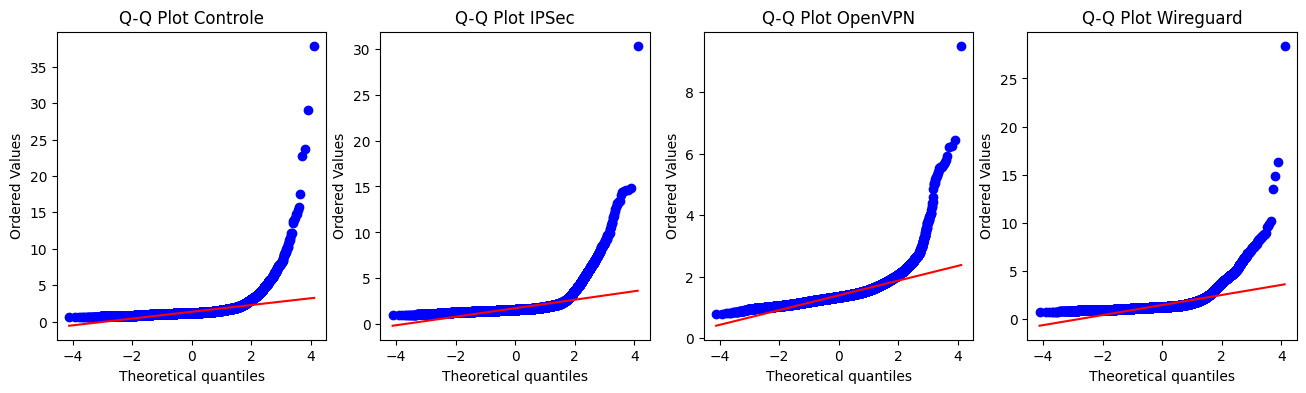

In [28]:
fig = plt.figure(figsize=(16, 4))

for i, vpn in enumerate(df['VPN'].unique()):
    # 4 columns 1 line
    subp = fig.add_subplot(1, 4, i+1)

    # Q-Q plot
    stats.probplot(df[df['VPN'] == vpn]['rtt'], dist="norm", plot=subp)

    subp.set_title(f"Q-Q Plot {vpn}") 

Após a transformação box-cox, ainda não temos um ajuste normal

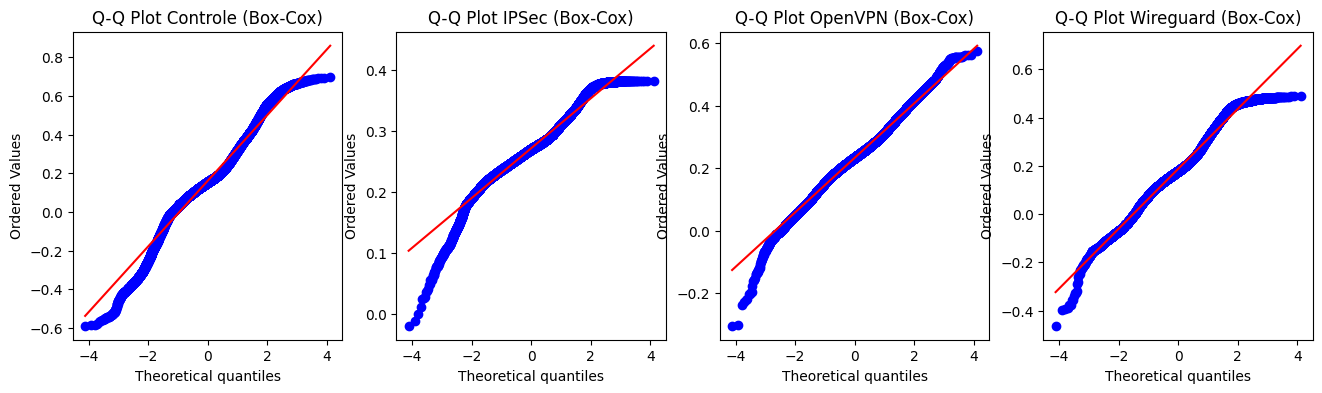

In [58]:
fig = plt.figure(figsize=(16, 4))

for i, vpn in enumerate(df['VPN'].unique()):
    # 4 columns 1 line
    subp = fig.add_subplot(1, 4, i+1)

    # boxcox
    ut, _ = stats.boxcox(df[df['VPN'] == vpn]['rtt'])

    # Q-Q plot
    stats.probplot(ut, dist="norm", plot=subp)

    subp.set_title(f"Q-Q Plot {vpn} (Box-Cox)") 

Teste de normalidade Kolmogorov-Smirnov, já que o Shapiro-Wilk não é adequado para amostras grandes

In [62]:
for i, vpn in enumerate(df['VPN'].unique()):
  boxcox, _ = stats.boxcox(df[df['VPN'] == vpn]['rtt'])

  result = stats.kstest(df[df['VPN'] == vpn]['rtt'], 'norm')
  result_boxcox = stats.kstest(boxcox, 'norm')

  print(f"{vpn}: Kolmogorov-Smirnov = {result}")
  print(f"{vpn} (box-cox): Kolmogorov-Smirnov = {result_boxcox}")
  print()

  if result.pvalue > 0.05:
    print(f"{vpn}: Segue uma distribuição normal")


Controle: Kolmogorov-Smirnov = KstestResult(statistic=0.7673577151823628, pvalue=0.0, statistic_location=0.8392333984375, statistic_sign=-1)
Controle (box-cox): Kolmogorov-Smirnov = KstestResult(statistic=0.400195758253652, pvalue=0.0, statistic_location=-0.06821087166529954, statistic_sign=-1)

IPSec: Kolmogorov-Smirnov = KstestResult(statistic=0.8842826274549092, pvalue=0.0, statistic_location=1.273393630981445, statistic_sign=-1)
IPSec (box-cox): Kolmogorov-Smirnov = KstestResult(statistic=0.5568104007664061, pvalue=0.0, statistic_location=0.17914627222061202, statistic_sign=-1)

OpenVPN: Kolmogorov-Smirnov = KstestResult(statistic=0.8358472451121945, pvalue=0.0, statistic_location=1.0199546813964844, statistic_sign=-1)
OpenVPN (box-cox): Kolmogorov-Smirnov = KstestResult(statistic=0.49808397121541664, pvalue=0.0, statistic_location=0.0344745653040457, statistic_sign=-1)

Wireguard: Kolmogorov-Smirnov = KstestResult(statistic=0.8096779911251544, pvalue=0.0, statistic_location=0.9002

Os dados NÃO seguem uma distribuição normal

Vamos comparar as VPNs com o grupo de controle usando o teste de Mann-Whitney U (não paramétrico)

-  H0: As amostras são iguais
-  H1: As amostras são diferentes

$\alpha = 0.05$ 

Se o p-valor for menor que $\alpha$, rejeitamos a hipótese nula

Ajustamos o p-valor para o número de comparações por Bonferroni

In [79]:
from statsmodels.stats.multitest import multipletests

VPNS = ['IPSec', 'OpenVPN', 'Wireguard']
CONTROLE = 'Controle'

controle_rtt = df[df['VPN'] == CONTROLE]['rtt']

resultados = []

for vpn in VPNS:
  rtt = df[df['VPN'] == vpn]['rtt']
  stat, p = stats.mannwhitneyu(rtt, controle_rtt, alternative='two-sided')
  resultados.append((vpn, stat, p))

# Ajuste de Bonferroni
p_values = [r[2] for r in resultados]
rej, p_ajustado, _, _ = multipletests(p_values, method='bonferroni')

for i, r in enumerate(resultados):
  print(f"Controle vs. {r[0]}: p-valor = {p_ajustado[i]} - Rejeita H_0: {rej[i]}")


Controle vs. IPSec: p-valor = 0.0 - Rejeita H_0: True
Controle vs. OpenVPN: p-valor = 0.0 - Rejeita H_0: True
Controle vs. Wireguard: p-valor = 0.0 - Rejeita H_0: True


Todas as VPNs diferem do grupo de controle com um nível de significância de 0.05. 

Agora partimos para o teste de Kruskal-Wallis para comparar as VPNs entre si

- H0: As distribuições de latência são iguais
- H1: Pelo menos uma VPN difere das outras

$\alpha = 0.05$

Se o p-valor for menor que $\alpha$, rejeitamos a hipótese nula

In [82]:
vpn_rtt = [df[df["VPN"] == vpn]["rtt"] for vpn in VPNS]

stat, p = stats.kruskal(*vpn_rtt)
print(f"Kruskal-Wallis: p-value = {p}")

if p < 0.05:
  print("Há diferença significativa entre as médias")

Kruskal-Wallis: p-value = 0.0
Há diferença significativa entre as médias


Agora podemos fazer uma comparação post hoc com o teste de Dunn

In [113]:
import scikit_posthocs as sp

dunn_data = df[["VPN", "rtt"]]
dunn_result = sp.posthoc_dunn(dunn_data, val_col="rtt", group_col="VPN", p_adjust="bonferroni")

print(dunn_result)
print()

for x in dunn_result.index:
    for y in dunn_result.columns:
      if x != y and dunn_result.loc[x, y] < 0.05:
        print(f"{x} vs {y}: Diferença significativa (p = {dunn_result.loc[x, y]})")
    
    print()

median_rtt = df.groupby("VPN")["rtt"].median().sort_values()
print("Latência mediana por VPN:")
print(median_rtt)

                Controle  IPSec  OpenVPN      Wireguard
Controle    1.000000e+00    0.0      0.0  2.922253e-265
IPSec       0.000000e+00    1.0      0.0   0.000000e+00
OpenVPN     0.000000e+00    0.0      1.0   0.000000e+00
Wireguard  2.922253e-265    0.0      0.0   1.000000e+00

Controle vs IPSec: Diferença significativa (p = 0.0)
Controle vs OpenVPN: Diferença significativa (p = 0.0)
Controle vs Wireguard: Diferença significativa (p = 2.9222526882745463e-265)

IPSec vs Controle: Diferença significativa (p = 0.0)
IPSec vs OpenVPN: Diferença significativa (p = 0.0)
IPSec vs Wireguard: Diferença significativa (p = 0.0)

OpenVPN vs Controle: Diferença significativa (p = 0.0)
OpenVPN vs IPSec: Diferença significativa (p = 0.0)
OpenVPN vs Wireguard: Diferença significativa (p = 0.0)

Wireguard vs Controle: Diferença significativa (p = 2.9222526882745463e-265)
Wireguard vs IPSec: Diferença significativa (p = 0.0)
Wireguard vs OpenVPN: Diferença significativa (p = 0.0)

Latência mediana por 

/home/bfsgr/.pyenv/versions/3.11.6/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/home/bfsgr/.pyenv/versions/3.11.6/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()
/tmp/ipykernel_2440915/2993728961.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to a

Com isso concluímos que as VPNs as VPNs tem uma diferença significativa entre si e que:
- O IPSec tem a maior latência mediana
- Seguido do OpenVPN
- E o WireGuard tem a menor latência mediana entre as VPNs

O grupo de Controle tem a menor latência mediana entre todos, como esperado

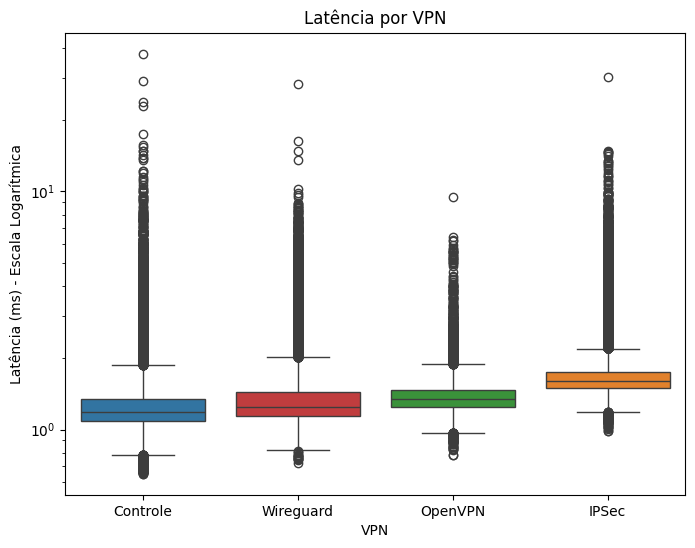

In [111]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x="VPN", y="rtt", data=df, hue='VPN', order=["Controle", "Wireguard", "OpenVPN", "IPSec"], log_scale=True)
plt.title("Latência por VPN")
plt.xlabel("VPN")
plt.ylabel("Latência (ms) - Escala Logarítmica")
plt.show()